In [86]:
import os
import time
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from skimage.feature import hog
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 12.0)

Reading 17760 images
******************Done extracting features
13320 training images and 4704 features
Fit in 12.65 s
Test acc 0.983


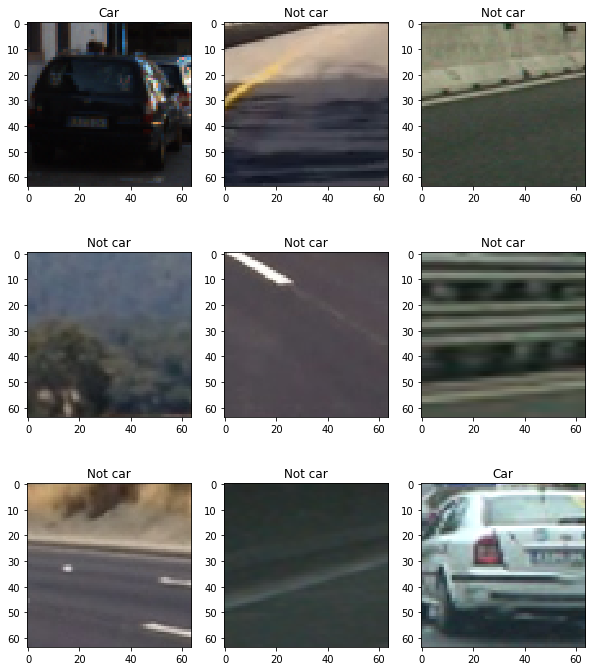

In [98]:
classifier = train_car_classifier('./data/vehicles/', 
                                  './data/non-vehicles/',
                                  display=True)

In [97]:
#------------------80-chars----------------------------------------------------|
def train_car_classifier(veh_path, nonveh_path, display=False):
    """
    Trains a classifier to recognize cars
    
    :param veh_path: Directory where vehicles images are found
    :param nonveh_path: Directory where non-vehicle images are found
    :param display: Whether to display information about progress and tests set
    :return classifier: A classifier that detects cars 
    """
    veh_files = retrieve_files(veh_path, 'png')
    nonveh_files = retrieve_files(nonveh_path, 'png')
    img_files = np.hstack((veh_files, nonveh_files))
    labels = np.hstack((np.ones(veh_files.shape[0]), 
                        np.zeros(nonveh_files.shape[0])))
    features = []
    if display:
        print('Reading {0} images'.format(len(img_files)))
    for count, img_file in enumerate(img_files):
        if count % 1000 == 0:
            if display:
                print('*', end='')
        img = mpimg.imread(img_file)
        if img.dtype == np.dtype(np.float32):
            img = np.uint8(img*255)
        features.append(get_classifier_features(img, color_space='HSV'))
    if display:
        print('Done extracting features')
    X = np.asarray(features)
    X_scaler = StandardScaler().fit(X)
    X_scaled = X_scaler.transform(X)

    X_train, X_test, y_train, y_test, img_train, img_test = train_test_split(
        X_scaled, labels, img_files)
    
    classifier = LinearSVC()
    t_i = time.time()
    classifier.fit(X_train, y_train)
    t_f = time.time()
    if display:
        print('{0} training images and {1} features'.format(X_train.shape[0],
                                                            X_train.shape[1]))
        print('Fit in {0:.2f} s'.format(t_f - t_i))
        print('Test acc {0:.3f}'.format(classifier.score(X_test, y_test)))
        for i in range(1, 10):
            test_img = mpimg.imread(img_test[i])
            ax = plt.subplot(3,3,i)
            prediction = classifier.predict(X_test[i].reshape(1, -1))
            if prediction == 1:
                ax.set_title('Car')
            else:
                ax.set_title('Not car')
            ax.imshow(test_img)
        plt.show()
    return classifier

In [45]:
#------------------80-chars----------------------------------------------------|
def retrieve_files(file_folder, file_format):
    """
    Returns an array of all image *files* in a folder with a specified format
    
    :param file_folder: Folder to find images as a string
    :param file_format: File format of the image as a string
    """
    if file_format[0] != '.':
        file_format = '.' + file_format
    image_files = glob.glob(file_folder + '/*/*' + file_format)
    return np.array([file for file in image_files])

In [5]:
#------------------80-chars----------------------------------------------------|
def load_images(file_folder, file_format):
    """
    Returns an array of all images in a folder with a specified format
    
    :param file_folder: Folder to find images as a string
    :param file_format: File format of the image as a string
    """
    if file_format[0] != '.':
        file_format = '.' + file_format
    image_files = glob.glob(file_folder + '/*/*' + file_format)
    return np.array([mpimg.imread(file) for file in image_files])

In [2]:
#------------------80-chars----------------------------------------------------|
def sliding_windows(img, window_size=64, overlap=0.5):
    """
    Return ndarray of windows image with overlap.
    
    :param img: Image to create windows from
    :param window_size: Window width and height 
    :param overlap: Decimal fraction of overlap
    :return windows: ndarray of windows
    """
    height = img.shape[0]
    width = img.shape[1]
    
    windows = []
    step = np.int(window_size*overlap)
    for y in range(0, height, step):
        for x in range(0, width, step):
            windows.append(np.array([y, y + step, x, x + step]))
    windows = np.asarray(windows, dtype=uint16)
    return windows

In [6]:
#------------------80-chars----------------------------------------------------|
def crop_image(img, x_usable=(0.0,1.0), y_usable=(0.4,1.0)):
    """
    Crop parts of the image where cars should not exist
    
    :param img: Image to be cropped
    :param x_usable: Tuple - Fraction of image 0-1 in x start-end that's usable
    :param y_usable: Tuple - Fraction of image 0-1 in y start-end that's usable
    """
    x_start = np.int(img.shape[0]*x_usable[0])
    x_end   = np.int(img.shape[0]*x_usable[1])
    y_start = np.int(img.shape[1]*y_usable[0])
    y_end   = np.int(img.shape[1]*y_usable[1])
    return img[x_start:x_end,y_start:y_end,:]

In [72]:
def convert_color(img, cspace='RGB'):
    """
    Converts an RGB image to the given color space
    Available - RGB, BGR, HSV, HLS, YUV, YCC, LUV, LAB
    
    :param img: Image to convert
    :param cspace: Colorspace to convert image to
    """
    
    if cspace == 'RGB':
        return img
    if cspace == 'BGR':
        return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    if cspace == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if cspace == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if cspace == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if cspace == 'YCC':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)
    if cspace == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if cspace == 'LAB':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

In [28]:
def bin_spatial(img, size=(32,32)):
    """
    Create feature to represent position of color in space
    
    :param img: Image to extract feature from
    :param size: Size at which to extract features
    """
    ch_0 = cv2.resize(img[:,:,0], size).ravel()
    ch_1 = cv2.resize(img[:,:,1], size).ravel()
    ch_2 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((ch_0, ch_1, ch_2))

In [73]:
#------------------80-chars----------------------------------------------------|
def color_hist(img, n_bins=32):
    """
    Create feature vector of an images distribution of colors with histograms
    
    :param img: Image to extract color features from
    :param n_bins: Number of bins to sort pixel intensities into
    """
    
    ch_0_hist = np.histogram(img[:,:,0], bins=n_bins)[0]
    ch_1_hist = np.histogram(img[:,:,1], bins=n_bins)[0]
    ch_2_hist = np.histogram(img[:,:,2], bins=n_bins)[0]
    return np.hstack((ch_0_hist, ch_1_hist, ch_2_hist))

In [79]:
def get_hog_features(img, channel, pix_per_cell, cell_per_block, orient):
    """
    Extract histogram of gradient features from an image
    
    :param img: Image to extract features from
    :param channel: Channel to include 0-1st, 1-2nd, 2-3rd, 3-all
    :param pix_per_cell: Pixels per hog cell
    :param cell_per_block: Cells ber hog block
    :param orient: Direction bins in histogram for HOG
    :return hog_feat: HOG feature vector
    """
    hog_feat = []
    if channel == 0 or channel == 3:
        hog_0 = hog(img[:,:,0], orientations=orient, 
                    pixels_per_cell=(pix_per_cell, pix_per_cell), 
                    cells_per_block=(cell_per_block, cell_per_block),
                    feature_vector=False, block_norm='L2-Hys')
        hog_feat.append(np.ravel(hog_0))
    if channel == 1 or channel == 3:
        hog_1 = hog(img[:,:,1], orientations=orient, 
                    pixels_per_cell=(pix_per_cell, pix_per_cell), 
                    cells_per_block=(cell_per_block, cell_per_block),
                    feature_vector=False, block_norm='L2-Hys')
        hog_feat.append(np.ravel(hog_1))
    if channel == 2 or channel == 3:
        hog_2 = hog(img[:,:,2], orientations=orient, 
                    pixels_per_cell=(pix_per_cell, pix_per_cell), 
                    cells_per_block=(cell_per_block, cell_per_block),
                    feature_vector=False, block_norm='L2-Hys')
        hog_feat.append(np.ravel(hog_2))
    hog_feat = np.hstack(hog_feat)
    return hog_feat
        

In [75]:
#------------------80-chars----------------------------------------------------|
def get_classifier_features(img, hist_bool=True, spatial_bool=True, 
                            hog_bool=True, color_space='RGB', hog_channel=3, 
                            pix_per_cell=8, cell_per_block=8, orient=8):
    """
    Combine different feature vectors together for each image
    
    :param img: Image to extract features from
    :param hist_bool: Whether or not to include histogram of color features
    :param spatial_bool: Whether or not to include spatial color features
    :param hog_bool: Whether or not to include histogram of gradient features
    :param color_space: Color space to convert features to before extracting
    :param hog_channel: Channel to include in HOG features. 0-1st, 3-all
    :param pix_per_cell: Pixels per hog cell
    :param cell_per_block: Cells ber hog block
    :param orient: Direction bins in histogram for HOG
    :return features: HOG feature vector
    """
    features = []
    height, width, _ = img.shape
    hist_feat = []
    spatial_feat = []
    hog_feat = []
    img = convert_color(img, cspace=color_space)
    #TODO: Loop over image
    if hist_bool:
        hist_feat = color_hist(img)
        features.append(hist_feat)
    if spatial_bool:
        spatial_feat = bin_spatial(img)
        features.append(spatial_feat)
    if hog_bool:
        hog_feat = get_hog_features(img, hog_channel, pix_per_cell, 
                                    cell_per_block, orient)
        features.append(hog_feat)
    features = np.hstack((hist_feat, spatial_feat, hog_feat))
    return features

In [2]:
def pipeline(img):
    """
    Pipeline detects vehicles in an image
    Uses global classifier to prevent passing large data a lot
    
    :param img: Image to detect cars in
    :return final_img: Image with bounding boxes around cars
    """
    return final_img